# 【第３回 課題2】Neural style transfer

In [1]:
# UEC 共通設定
import os
# CED/IEDでの proxy の設定．
# keras.datasetsやkeras.applicationsでは，dataset, pretrained modelを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"      # "0":GPU0,..., "7":GPU7 を使用

# CED/IEDを自動判定して，datadir をセット．
cdir=os.getcwd()
if '/IED_HOME/' in cdir or '/.ced_ubuntu/' in cdir:
    datadir="/ced-home/staff/yanai/media/"
else:
    datadir="/usr/local/class/object/media/"

# 結果を出力するディレクトリを作成
outdir='result'
os.makedirs(outdir, exist_ok=True)

In [2]:
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
import keras

Using TensorFlow backend.


using GPU: 0


DeepDream は，ニューラルネットを使った画像生成として話題を集めましたが，もう一つ話題になった技術があります．それが，Neural Style Transfer です．日本語では「スタイル変換」とか「画風変換」などと呼ばれます．

写真がゴッホ風やムンク風に変換されたのは見たことがあるかと思います．

アプリだと[Prisma](https://prisma-ai.com/)などが有名ですね．（柳井研でも [DeepStyleCam](https://apps.apple.com/jp/app/deepstylecam-v2/id1468257766)
をリリースしています．iPhone 8以降に対応です．）

課題1と同様に原理を簡単に理解してから，実際に動かしてみましょう．なお，ネット上に解説が多数あります．興味のある人は[PFIの解説](https://research.preferred.jp/2015/09/chainer-gogh/)などを見るといいでしょう．

なお，こちらもコードはKerasの作者による「Deep Learning with Python」のものを利用しています．

### スタイル変換 とは？

以下に示すように，コンテンツ画像とスタイル画像を入力とし，写真中の意味的な内容はそのままでスタイル（画風）だけスタイル画像から転写する技術です．ゴッホの絵を用意すれば，写真がゴッホ風に変換できます．

従来は写真を絵画風にするような研究はコンピュータグラフィクスの研究として行われていましたが，ニューラルネットの応用として数値計算のみで画風の転送ができるということで，実用的な応用はさておいて，2015年の夏に発表されたときは革新的な技術として話題を集めました．

2015年以降，このスタイル変換技術の高速化，ビデオへの適用，物体の質感の変換，フォント生成などへの応用の研究が盛んに行われて，スタイル変換一大研究ブームを巻き起こしています．

以下のようにコンテンツ画像とスタイル画像を入力として，スタイルの画風をコンテンツ画像に転送された画像が合成されます．

これもDeepDreamと同様の画像の最適化によって，実現されています．

![style transfer](https://s3.amazonaws.com/book.keras.io/img/ch8/style_transfer.png)

以下の図では，北斎の東海道５３次の絵がスタイル画像，コンテンツ画像は上記と同じドイツのチュビンゲンの町並みです．（提案者がドイツ人なので，サンプルとしてよく使われます．）

それぞれの入力画像を 前回も使った1000種類画像認識ネットワークであるVGG16に入力して，relu3_3 からコンテンツ画像の信号を，relu1_2, relu2_2, relu3_3, relu4_3 から，スタイル画像の信号をそれぞれ取り出します．

コンテンツ画像の信号は 特徴マップそのままです．特徴マップには入力画像の形状，つまり空間的な情報が保存されています．

一方，スタイル画像を入力した時に４つのレイヤから取り出した信号は，グラム行列に変換されます．グラム行列とは，特徴マップの各チャネル同士の内積で，空間方向については内積が取られてしまうので，グラム行列には空間な情報は含まれておらず，局所的にどのフィルタとどのフィルタが同時に反応したかという情報の空間方向での強度情報が表現されています．つまり，**テクスチャの分布情報**を表現しているといえます．４箇所から信号を取り出しているのは，入力に近いレイヤでは細かいテクスチャ，後ろに行くにつれ，より大局的なパターンのテクスチャを表現しているため，様々なスケールのテクスチャを取り出すために４箇所から信号を取り出しています．(なお，これは4つに限定する必要はなくて，以下のKerasの実装では5箇所から取り出しています．)


<!--<table><TR><TD><img src="img/tamon.jpg" width=200></TD><TD> **+** </TD><TD><img src="img/scream-style.jpg" width=200></TD><TD>** = ** </TD><TD><img src="img/tamon_scream.png" width=200></td></tr></table>-->

![](fig/styletransfer.png)

次に，コンテンツ画像のコンテンツ特徴（relu3_3の特徴マップ）と，スタイル画像のスタイル特徴(4つのレイヤの特徴マップのグラム行列)に，
生成画像 (generated_imaghe)のコンテンツ特徴とスタイル特徴が近づくように出力画像を繰り返し更新していきます．以下の式が
最小化すべき関数で，これを出力画像を更新することによって，最小化します．

```
loss = distance(style(style_image) - style(generated_image)) +
       distance(content(conten_image) - content(generated_image))
```

### Kerasによるニューラルスタイル変換

In [3]:
from keras.preprocessing.image import load_img, img_to_array

# コンテント画像のファイル名です．
target_image_path = 'img/tamon.jpg'   # 有名な深大寺の多聞そば．

# スタイル画像のファイル名です．
# img/ に night-style.jpg, scream-style.jpg, wave-style.jpg がサンプルとしてあります．
style_reference_image_path = 'img/night-style.jpg'

# Dimensions of the generated picture.
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [4]:
import numpy as np
from keras.applications import vgg16

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

<!--
Let's set up the VGG19 network. It takes as input a batch of three images: the style reference image, the target image, and a placeholder 
that will contain the generated image. A placeholder is simply a symbolic tensor, the values of which are provided externally via Numpy 
arrays. The style reference and target image are static, and thus defined using `K.constant`, while the values contained in the placeholder 
of the generated image will change over time.-->

In [5]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# This placeholder will contain our generated image
combination_image = K.placeholder((1, img_height, img_width, 3))

# We combine the 3 images into a single batch
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# We build the VGG19 network with our batch of 3 images as input.
# The model will be loaded with pre-trained ImageNet weights.
model = vgg16.VGG16(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model loaded.')

Model loaded.


In [6]:
# model.summary()

コンテンツに関する損失関数

In [7]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

スタイルに関する損失関数

In [8]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

Total variation loss は，隣接画素間の連続性を保つための損失関数．生成画像がなめらかになるようにするための工夫．

In [9]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

コンテンツ特徴は block5_conv2, スタイル特徴は block{1,2,3,4,5}_conv1 から抽出．

model.summary() をみてみましょう．

<!--The loss that we minimize is a weighted average of these three losses. To compute the content loss, we only leverage one top layer, the 
`block5_conv2` layer, while for the style loss we use a list of layers than spans both low-level and high-level layers. We add the total 
variation loss at the end.

Depending on the style reference image and content image you are using, you will likely want to tune the `content_weight` coefficient, the 
contribution of the content loss to the total loss. A higher `content_weight` means that the target content will be more recognizable in 
the generated image.-->

In [10]:
# Dict mapping layer names to activation tensors
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# Name of layer used for content loss
content_layer = 'block5_conv2'
# Name of layers used for style loss
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
# Weights in the weighted average of the loss components
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

# Define the loss by adding all components to a `loss` variable
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(style_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

L-BFGS algorithm という方法を SGDの代わりに使って最適化します．SGDでもできますが，元論文が L-BFGS algorithmを使っていたので，多くの実装では，L-BFGS algorithmを使っています．一般に収束がSGDよりも早くなると言われています．

In [11]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [12]:
from scipy.optimize import fmin_l_bfgs_b
import time

iterations = 30 # 繰り返し回数

x = preprocess_image(target_image_path)
x = x.flatten()
st=time.time()
for i in range(iterations):
    if i%5==0:
        print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x, fprime=evaluator.grads, maxfun=20)
    if i%5==0:
        print('Current loss value:', min_val)
    # Save current generated image
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    if i%5==0:   
        end_time = time.time()
        print('Iteration %d completed in %ds (total time %ds)' % (i, end_time - start_time, end_time-st))

Start of iteration 0
Current loss value: 422367940.0
Iteration 0 completed in 5s (total time 5s)
Start of iteration 5
Current loss value: 24566876.0
Iteration 5 completed in 3s (total time 23s)
Start of iteration 10
Current loss value: 14379807.0
Iteration 10 completed in 3s (total time 41s)
Start of iteration 15
Current loss value: 10849789.0
Iteration 15 completed in 3s (total time 59s)
Start of iteration 20
Current loss value: 8790869.0
Iteration 20 completed in 3s (total time 78s)
Start of iteration 25
Current loss value: 7898104.5
Iteration 25 completed in 3s (total time 96s)


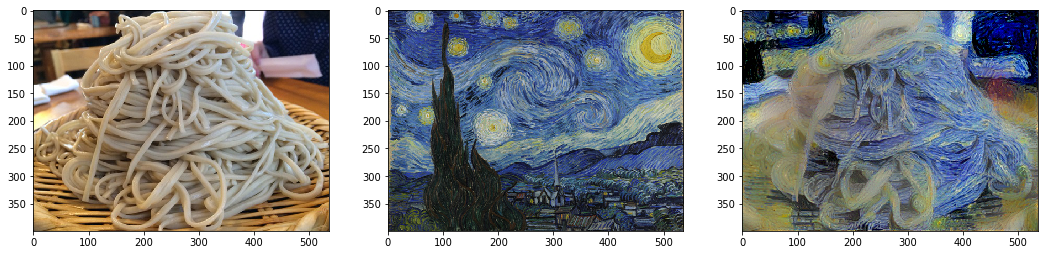

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

plt.figure(figsize=(18,6))

# Content image
plt.subplot(131)
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))

# Style image
plt.subplot(132)
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))

# Generate image
plt.subplot(133)
plt.imshow(img)

plt.savefig(outdir+'/styletransfer.png') 
plt.show()

## 課題2

以下の小問の(1)を解答せよ． **(課題提出には解答シートを使って下さい．)**

1. 上記以外のコンテンツ画像2枚，スタイル画像2枚について変換してみよ．絵画画像は，[WikiArt](https://www.wikiart.org/) で探すとよい．

In [15]:
# GPUメモリの開放
from numba import cuda
cuda.select_device(0)
cuda.close()